In [1]:
# Comparison of training between to similar nets: one classical feedforward and one FGN
# here you can see that a similar FGN (same size per hidden units) can perform as well as classical feedforward network

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import scipy as sp
from scipy import stats
from sklearn.datasets import make_moons

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device

torch.cuda.set_device(1)

CUDA Available:  True
Using device: cuda


In [6]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [7]:
# MNIST dataset and dataloader declaration
# transforms does both the conversion from 0-255 to 0-1
# and normalizes by the precomputed mean and std

batch_size = 1024

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../MNIST-dataset', train=True, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../MNIST-dataset', train=False, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=True)

Shape: torch.Size([60000, 28, 28])
type: <type 'numpy.ndarray'>
shape: torch.Size([28, 28])
Label: 0
type: <class 'torch.Tensor'>


<IPython.core.display.Javascript object>


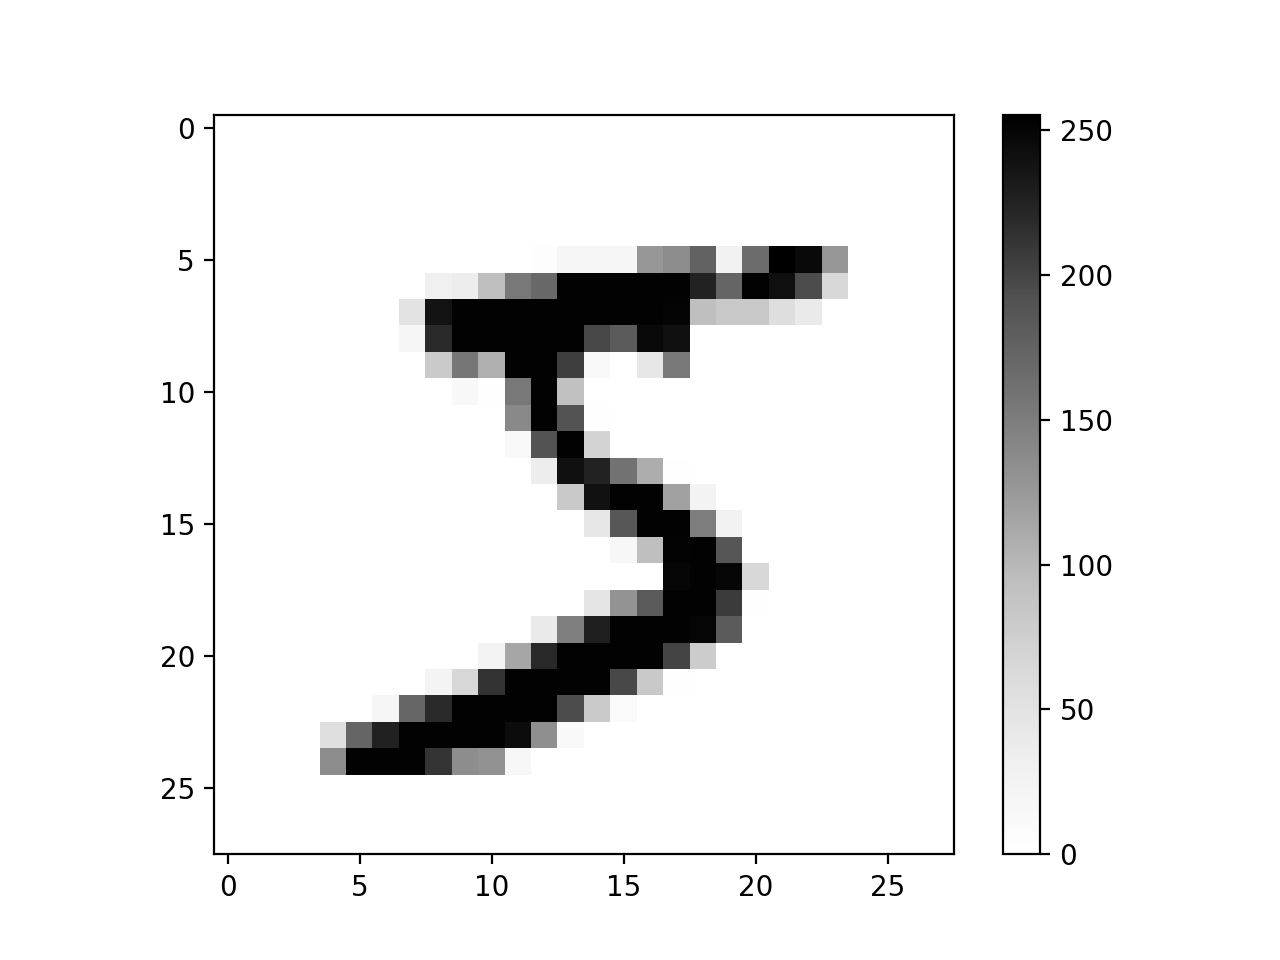

In [8]:
# show an example
print("Shape:", mnist_train_loader.dataset.train_data.shape)
x = mnist_train_loader.dataset.train_data[0]
print("type:", type(x.numpy()))
print("shape:", x.shape)
# print("sample:", x.numpy())

y = mnist_train_loader.dataset.train_labels[1]
print("Label:",y.numpy())
print("type:", type(y))

plt.imshow(x, cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()
plt.show()

In [9]:
# loss functions for the classic net
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
print(lmbda_l2)
      
def l2_loss(model):
    # sum of w^2 for regularizer 
    for p in model.named_parameters():
        if ('weight' in p[0]) or ('bias' in p[0]):
            try:
                l2 += torch.sum(p[1]**2)
            except:
                l2 = torch.sum(p[1]**2)          
    return l2


def classical_cross_ent_loss(model, output, target):
    cent_loss = F.cross_entropy(output, target.long())
    l2 = l2_loss(model)
    return cent_loss + lmbda_l2*l2

6.66666666667e-06


In [10]:
# Initialize the classic network
hidden_l_nums = [32,32]
drop_p= 0.0

In [11]:
classic_model = fgnl.Feedforward_Classic_net(in_feats=28*28, out_feats=10, hidden_l_nums=hidden_l_nums, drop_p=drop_p).to(device)

In [12]:
classic_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, classic_model.parameters()),momentum=0.5)

In [13]:
# train the model
epochs = 50

In [14]:
classic_train_res = fgnh.train(classic_model, device, mnist_train_loader, 
                             classical_cross_ent_loss, classic_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_test_loader)

Epoch 0 Train set - Average loss: 0.6255, Accuracy: 48147/60000 (80%)
Test set - Average loss: 0.3651, Accuracy: 8983/10000 (90%)
Epoch 1 Train set - Average loss: 0.3432, Accuracy: 54209/60000 (90%)
Test set - Average loss: 0.3274, Accuracy: 9064/10000 (91%)
Epoch 2 Train set - Average loss: 0.2984, Accuracy: 54989/60000 (92%)
Test set - Average loss: 0.3014, Accuracy: 9143/10000 (91%)
Epoch 3 Train set - Average loss: 0.2756, Accuracy: 55265/60000 (92%)
Test set - Average loss: 0.2728, Accuracy: 9240/10000 (92%)
Epoch 4 Train set - Average loss: 0.2595, Accuracy: 55694/60000 (93%)
Test set - Average loss: 0.2833, Accuracy: 9227/10000 (92%)
Epoch 5 Train set - Average loss: 0.2515, Accuracy: 55784/60000 (93%)
Test set - Average loss: 0.2733, Accuracy: 9247/10000 (92%)
Epoch 6 Train set - Average loss: 0.2377, Accuracy: 56093/60000 (93%)
Test set - Average loss: 0.2350, Accuracy: 9366/10000 (94%)
Epoch 7 Train set - Average loss: 0.2308, Accuracy: 56237/60000 (94%)
Test set - Average l

In [15]:
### Loss Functions for the FGN

# importances of the constraints
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
lmbda_sigs = 10.01*lmbda_l2
# sig_params = sum(p.numel() for n,p in fgn_model.named_parameters() if 'sigs' in n)
# lmbda_sigs = (1.0/sig_params)

# lmbda_l2 = 0.0
# lmbda_sigs = 0.0
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)

# loss functions
def sigmas_loss(model):
    # sum of sigma^2 for regularizer 
    for p in model.named_parameters():
        if 'sigs' in p[0]:
            try:
                sig_loss += torch.sum(p[1]**2)
            except:
                sig_loss = torch.sum(p[1]**2)
                
    return sig_loss


def fgn_cross_ent_loss(model, output, target):
    
    # normal Cent loss
    cent_loss = F.cross_entropy(output, target.long())
    # normal l2 loss
    l2 = l2_loss(model)
    #sigma loss
    sig_loss = sigmas_loss(model)
    
    return cent_loss + lmbda_l2*l2 + lmbda_sigs*sig_loss


lambda for l2 loss 6.66666666667e-06
lambda for sigs^2 loss 6.67333333333e-05


In [16]:
# Initialize the fgn network
print("hidden layers",hidden_l_nums)
print("drop_p=", drop_p)
fgn_model = fgnl.Feedforward_FGN_net(in_feats=28*28, out_feats=10, hidden_l_nums=hidden_l_nums, drop_p=drop_p).to(device)

hidden layers [32, 32]
drop_p= 0.0


In [17]:
fgn_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, fgn_model.parameters()),momentum=0.5)

In [18]:
fgn_train_res = fgnh.train(fgn_model, device, mnist_train_loader, 
                             fgn_cross_ent_loss, fgn_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_test_loader)

Epoch 0 Train set - Average loss: 39.4093, Accuracy: 33271/60000 (55%)
Test set - Average loss: 35.0848, Accuracy: 4854/10000 (49%)
Epoch 1 Train set - Average loss: 30.8689, Accuracy: 52331/60000 (87%)
Test set - Average loss: 28.3199, Accuracy: 8635/10000 (86%)
Epoch 2 Train set - Average loss: 26.1567, Accuracy: 54367/60000 (91%)
Test set - Average loss: 24.2181, Accuracy: 8855/10000 (89%)
Epoch 3 Train set - Average loss: 22.4150, Accuracy: 55271/60000 (92%)
Test set - Average loss: 20.8126, Accuracy: 8902/10000 (89%)
Epoch 4 Train set - Average loss: 19.2386, Accuracy: 55822/60000 (93%)
Test set - Average loss: 17.8014, Accuracy: 9184/10000 (92%)
Epoch 5 Train set - Average loss: 16.4692, Accuracy: 56107/60000 (94%)
Test set - Average loss: 15.2331, Accuracy: 9189/10000 (92%)
Epoch 6 Train set - Average loss: 14.0303, Accuracy: 56345/60000 (94%)
Test set - Average loss: 12.9431, Accuracy: 9186/10000 (92%)
Epoch 7 Train set - Average loss: 11.8752, Accuracy: 56594/60000 (94%)
Test 

<IPython.core.display.Javascript object>


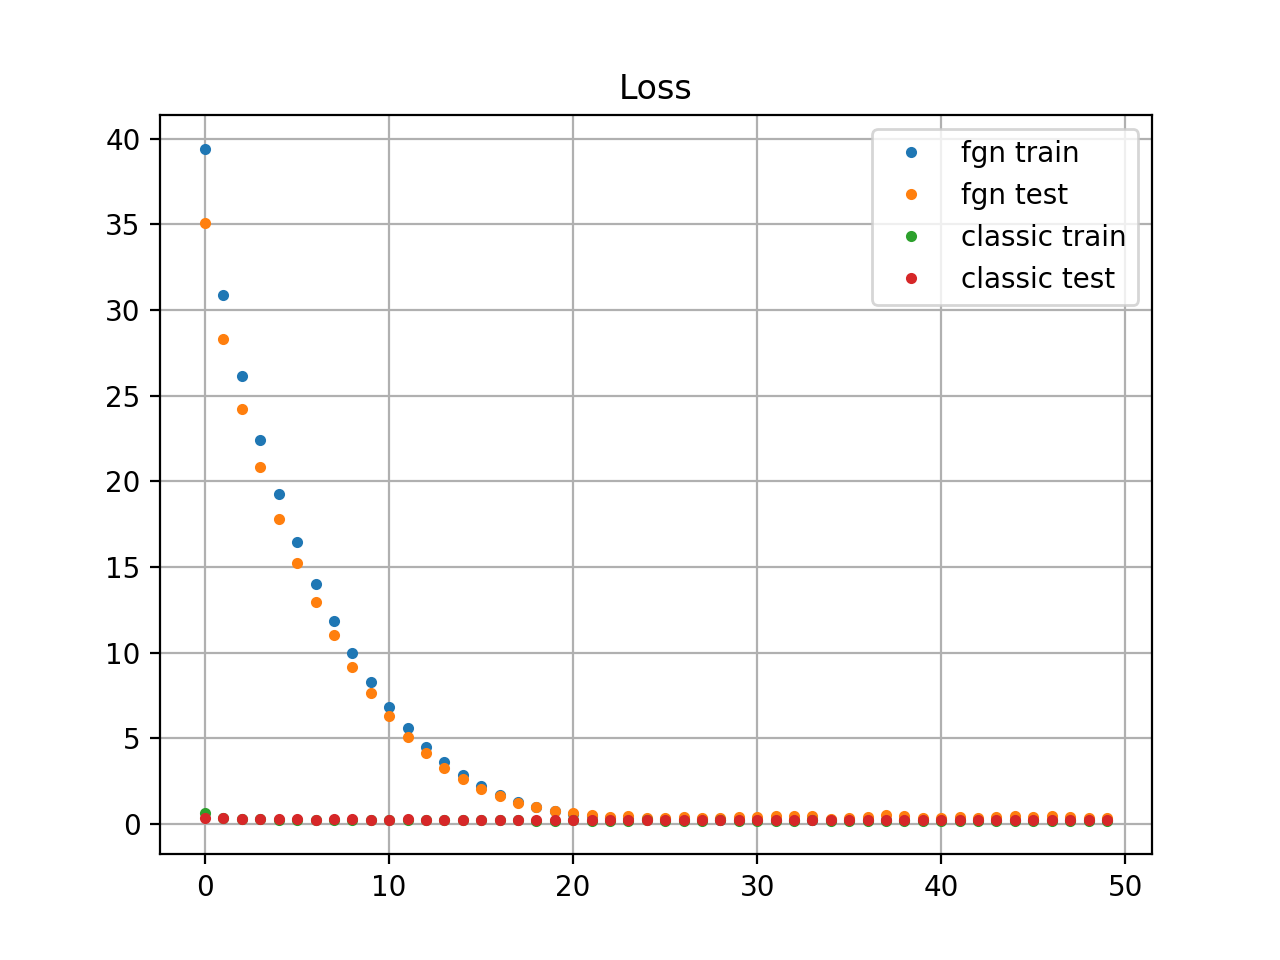

<IPython.core.display.Javascript object>


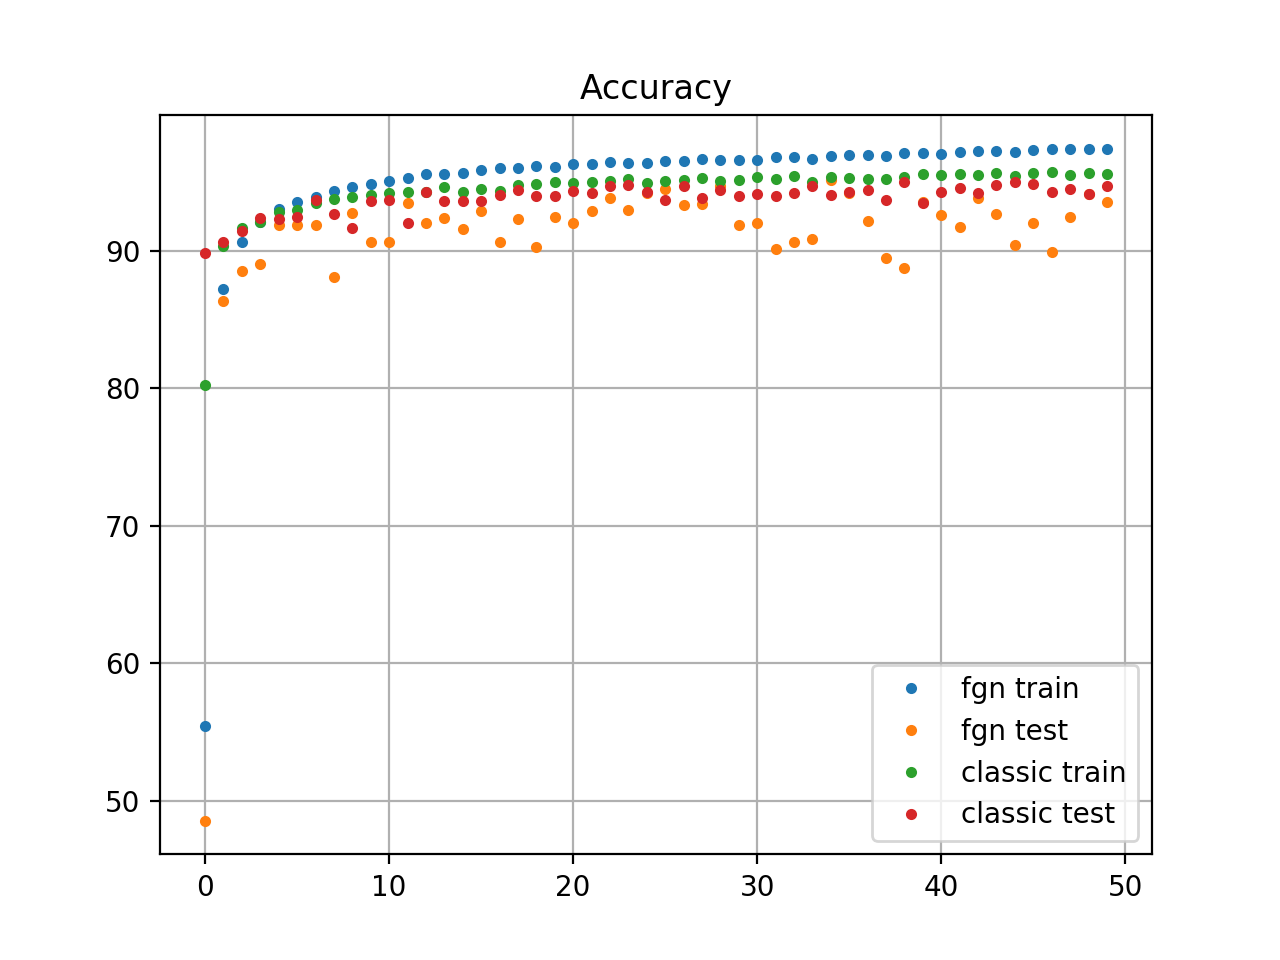

In [19]:
# acc and loss hist
plt.plot(fgn_train_res['train_loss_hist'], marker='.', linestyle=' ', label='fgn train')
plt.plot(fgn_train_res['test_loss_hist'], marker='.', linestyle=' ', label='fgn test')
plt.plot(classic_train_res['train_loss_hist'], marker='.', linestyle=' ', label='classic train')
plt.plot(classic_train_res['test_loss_hist'], marker='.', linestyle=' ', label='classic test')
plt.grid()
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(fgn_train_res['train_acc_hist'], marker='.', linestyle=' ', label='fgn train')
plt.plot(fgn_train_res['test_acc_hist'], marker='.', linestyle=' ', label='fgn test')
plt.plot(classic_train_res['train_acc_hist'], marker='.', linestyle=' ', label='classic train')
plt.plot(classic_train_res['test_acc_hist'], marker='.', linestyle=' ', label='classic test')
plt.grid()
plt.legend()
plt.title('Accuracy')
plt.show()

fl.centers
plotting neurons: [1 4]


<IPython.core.display.Javascript object>


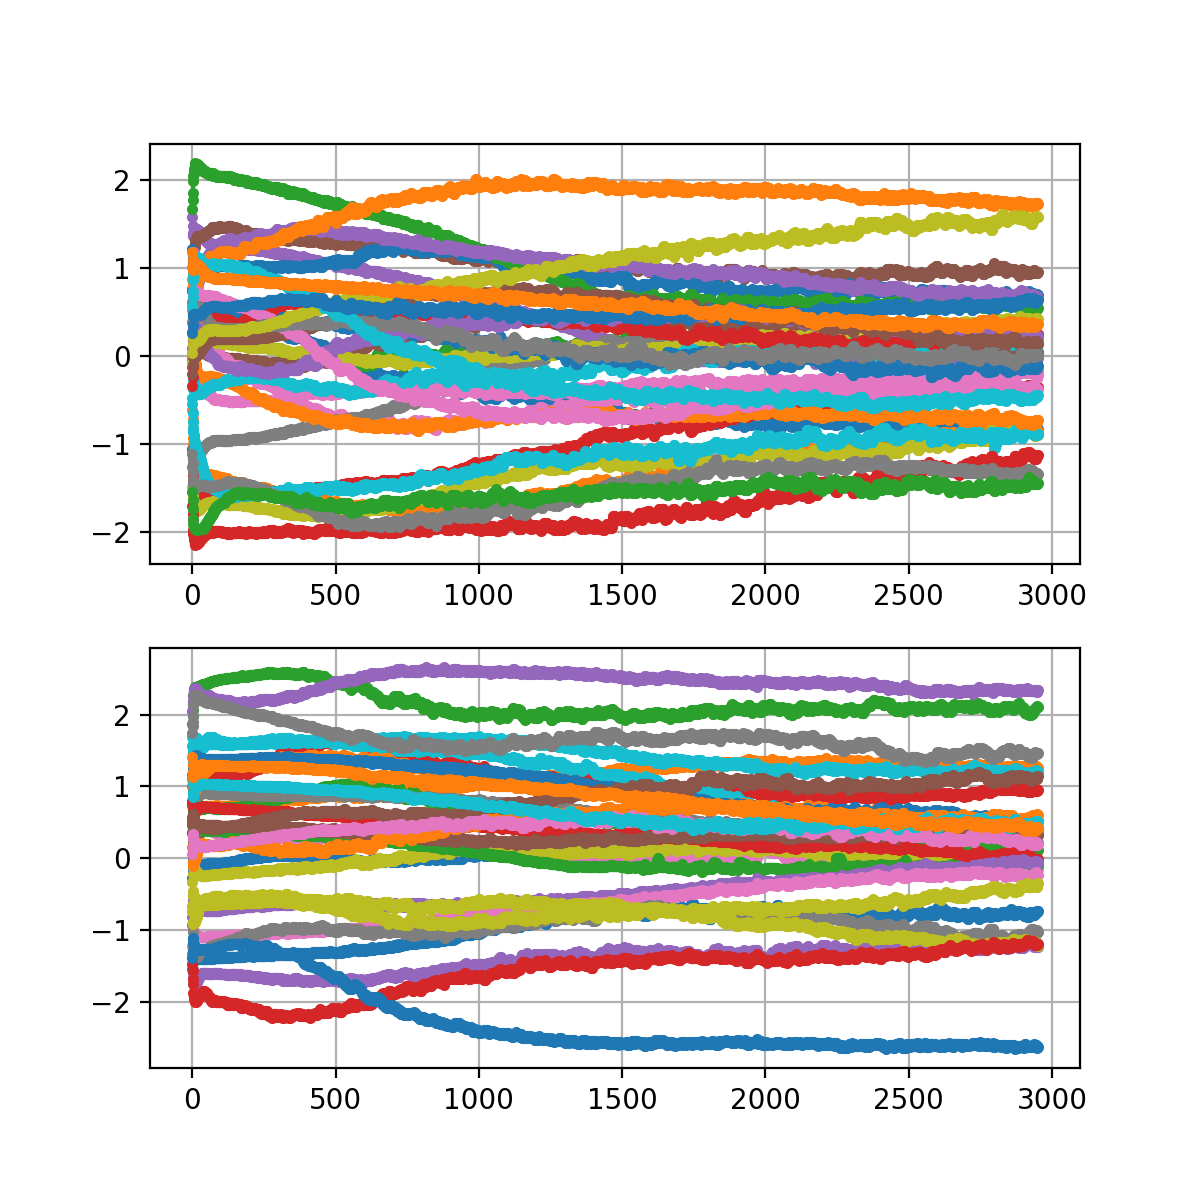

hidden_layers.2.centers
plotting neurons: [20  3]


<IPython.core.display.Javascript object>


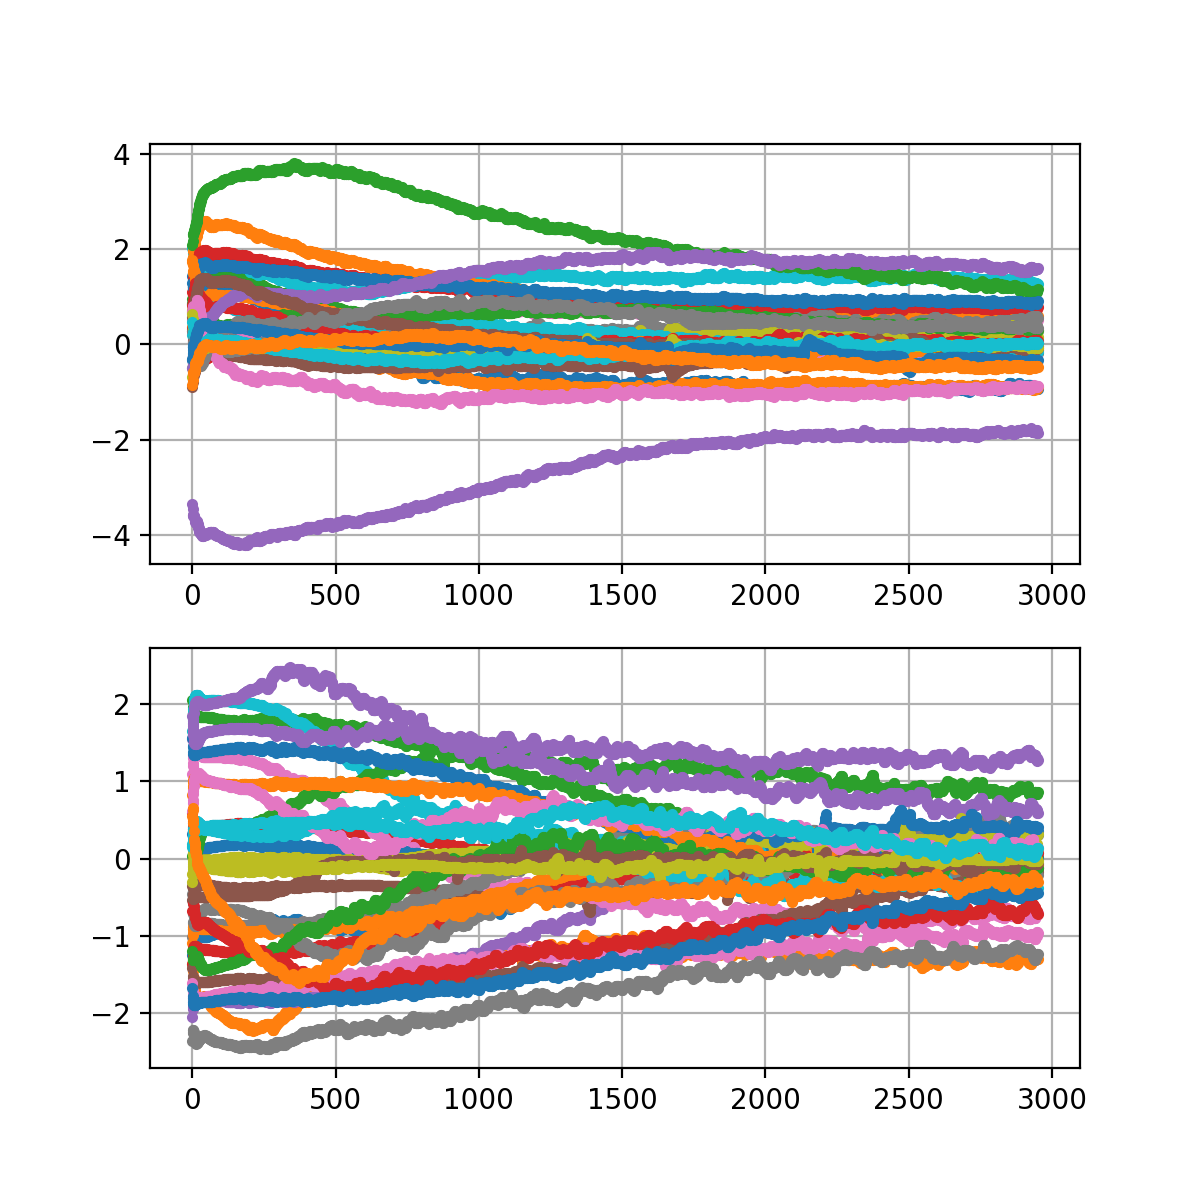

hidden_layers.0.centers
plotting neurons: [ 6 29]


<IPython.core.display.Javascript object>


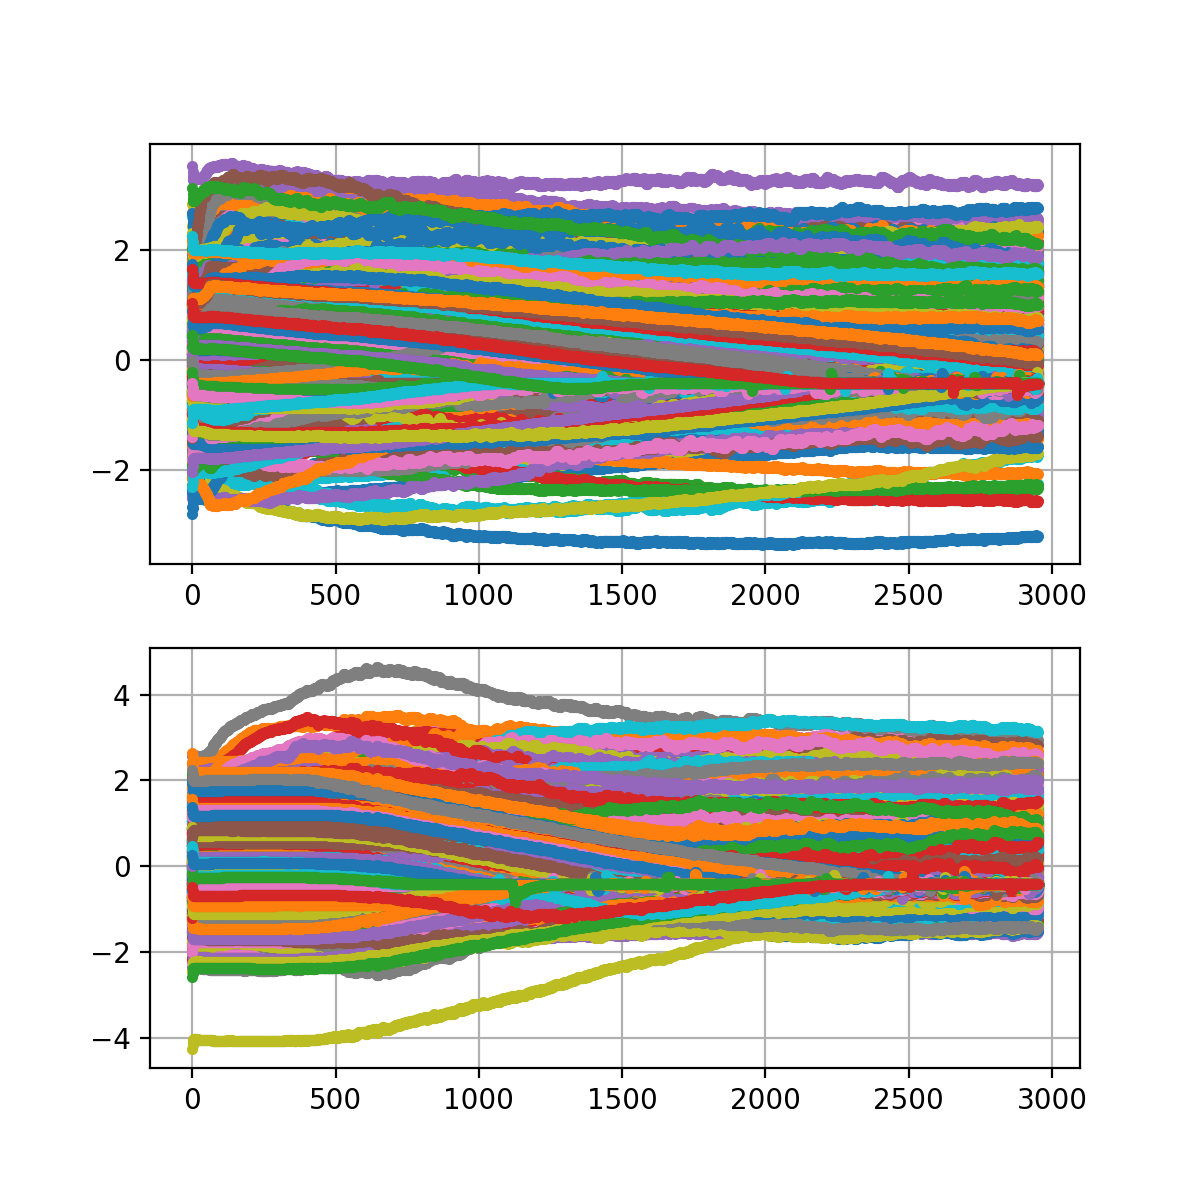

In [20]:
# plot centers history for only some hidden layer neuron

for k in fgn_train_res['histories'].keys():
    if 'centers' in k:
        print(k)
        plt.figure(figsize=(6,6))
        # print(np.shape(fgn_fgn_train_res['histories'][k]))
        # choose 4random neurons in the layer to print
        neurons =  np.random.choice(range(np.shape(fgn_train_res['histories'][k])[1]),2, replace=False)
        print("plotting neurons:", neurons)
        # plt.figure(figsize=(2,2))

        for idx,n in enumerate(neurons):
            x = fgn_train_res['histories'][k][:,n,:]
            # print(np.shape(x))
            plt.subplot(2,1,idx+1)
            plt.plot(x, marker='.', linestyle='-')
            # plt.axis([-3,3, -3, 3])
            plt.grid()
        plt.show()
            
            

hidden_layers.0.sigs


<IPython.core.display.Javascript object>


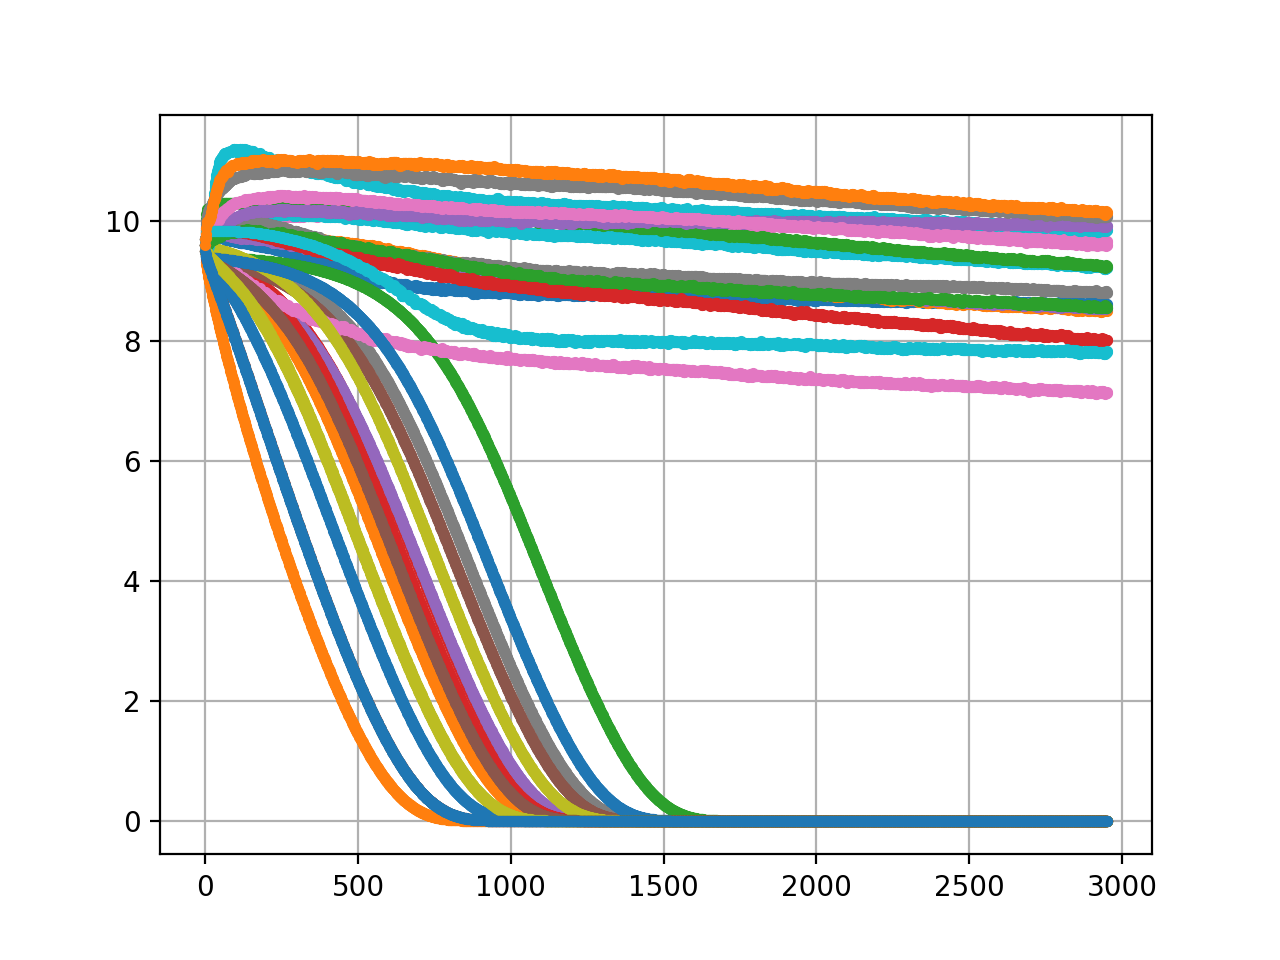

hidden_layers.2.sigs


<IPython.core.display.Javascript object>


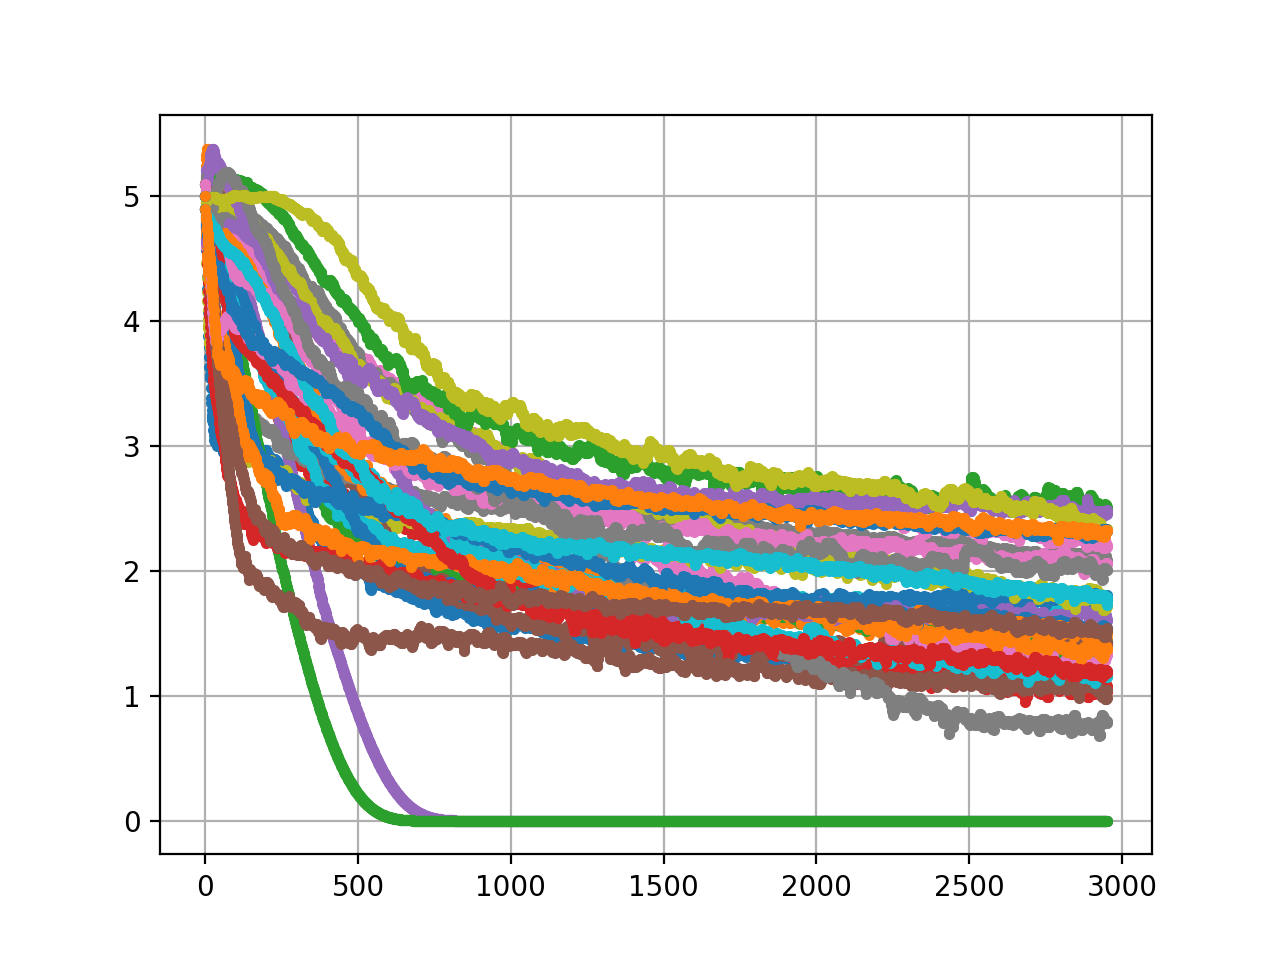

fl.sigs


<IPython.core.display.Javascript object>


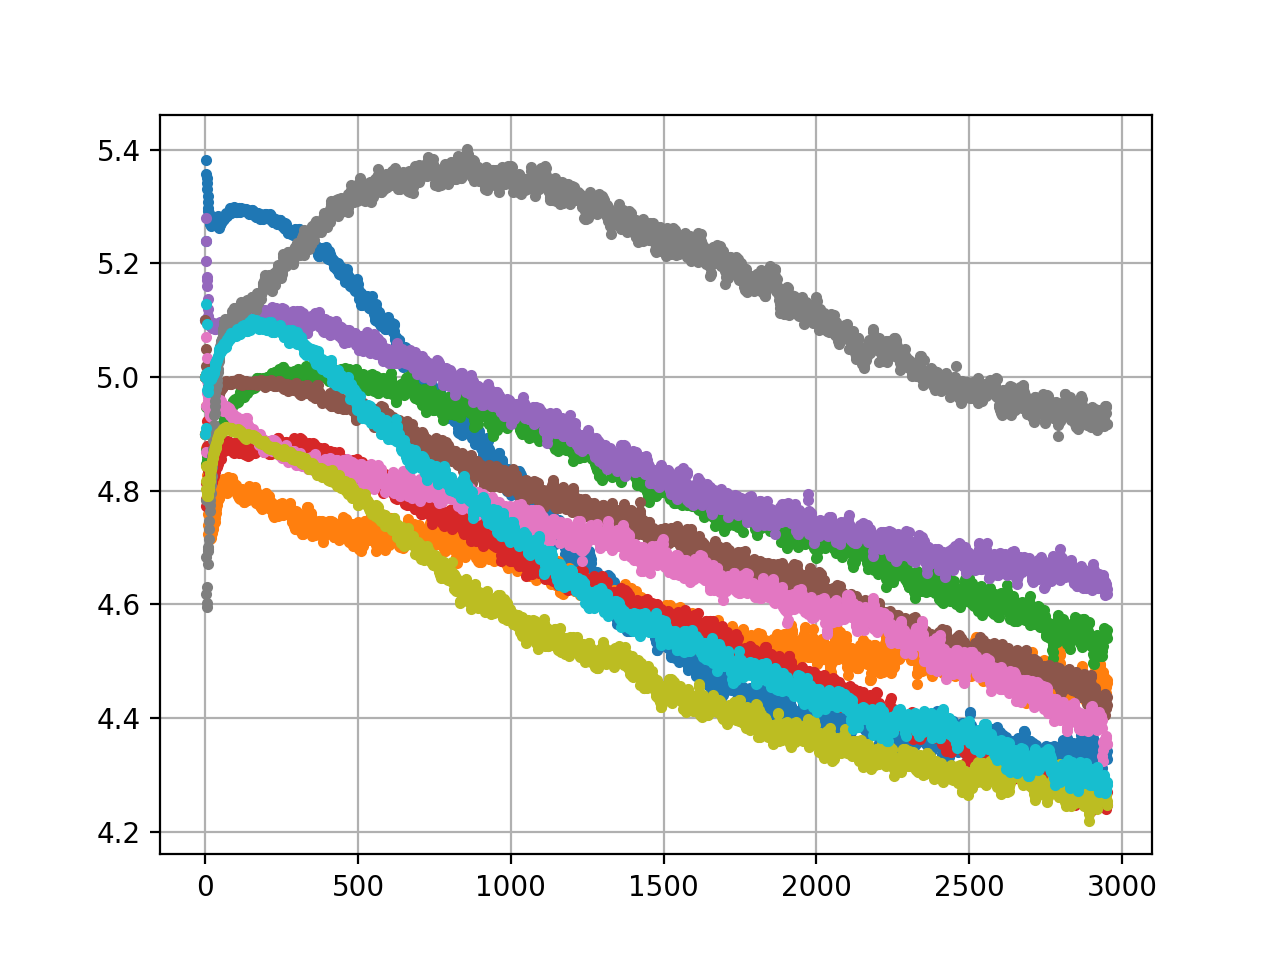

In [21]:
# check that sigma has shrunk
# plot sigma history
for k in fgn_train_res['histories'].keys():
    if 'sigs' in k:
        print(k)
        for i in range(len(fgn_train_res['histories'][k][0])):
            plt.plot(fgn_train_res['histories'][k][:,i], marker='.', linestyle=' ')
        plt.grid()
        plt.show()